# Colaboratoryで実行する場合
以下を実行して、外部ファイルをダウンロードしてください。   
**このセルはColaboratoryを起動するたびに必要となります**   
**<font color='red'>和文フォントをインストールしています。以下のセルを実行後、ランタイムをリスタートしてください。</font>**

In [ ]:
##################################
### Colaboratoryのみ以下を実行 ###
##################################
import sys
if 'google.colab' in sys.modules:
    !wget -P ./text http://www.hal.t.u-tokyo.ac.jp/~yamakata/lecture/mediaproc/mediaproc4/mediaproc4-2.zip
    !unzip text/mediaproc4-2.zip -d text/
    # 以下は日本語フォントをインストールするコマンドです
    !apt-get -y install fonts-ipafont-gothic
    !rm /root/.cache/matplotlib/*.json

# トピック分析2: tf-idfによる重要語抽出


## 1. 様々なトピックの記事の読み込み

`text/wikipedia_wakati.json`には、[Wikipediaからダウンロード](https://ja.wikipedia.org/wiki/Wikipedia:%E3%83%87%E3%83%BC%E3%82%BF%E3%83%99%E3%83%BC%E3%82%B9%E3%83%80%E3%82%A6%E3%83%B3%E3%83%AD%E3%83%BC%E3%83%89)してきたデータから、
以下に挙げる６種類のカテゴリについて、そのカテゴリのラベル、およびそのサブカテゴリのラベルを持つ記事を集め、
さらに分かち書きしたデータが記録されています（ただし、記事の数や文字数はカテゴリごとに違いがあるので、サイズをそろえるため、それぞれ1MB分のデータを使用しました）。  
括弧「()」内のラベルは、jsonファイルにおけるそのカテゴリのキーです。

- 動物 (`animal`)
- 芸術（`art`)
- 経済 (`economy`)
- 法 (`law`)
- 植物 (`plant`)
- 政治 (`politics`)

jsonファイル`text/wikipedia_wakati.json`の形式は以下の通りです。   

```
{
    "[カテゴリキー：例）animal]": {
        "[記事ID：例）1238]": {
            "url": "[その記事のURL：例）https://ja.wikipedia.org/wiki?curid=1238]",
            "title": "[その記事のタイトル：例）脳科学]",
            "wakati": "[その記事の本文の分かち書き文：例）脳 科学 （ の う か がく 、 ） と は 、...]"
        },
    ...
}
```


なお、ウィキペディアのコンテンツは Creative Commons Attribution-ShareAlike 3.0 Unported License (CC-BY-SA) および GNU Free Documentation License (GFDL) の下にライセンスされています。  
本授業で配布するデータも同じくこれらのライセンスを継承します。  
詳しくは[こちら](https://ja.wikipedia.org/wiki/Wikipedia:%E3%83%87%E3%83%BC%E3%82%BF%E3%83%99%E3%83%BC%E3%82%B9%E3%83%80%E3%82%A6%E3%83%B3%E3%83%AD%E3%83%BC%E3%83%89)を参照してください。
<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-sa.png" width=100>

In [2]:
import json

Categories = ['animal', 'art', 'economy', 'law', 'plant', 'politics']

with open('text/wikipedia_wakati.json', 'r', encoding='utf-8') as fi:
    wiki = json.load(fi)

# 各カテゴリに含まれる記事の数
print([len(wiki[cate]) for cate in Categories])

# 記事を1つだけ出力してみましょう
for doc in wiki['animal']:
    print('docID:' , doc)
    print('title:', wiki['animal'][doc]['title'])
    print('url:', wiki['animal'][doc]['url'])
    print('wakati:', wiki['animal'][doc]['wakati'])
    break


[443, 418, 194, 196, 569, 281]
docID: 1238
title: 脳科学
url: https://ja.wikipedia.org/wiki?curid=1238
wakati: 脳 科学 （ の う か がく 、 ） と は 、 ヒト を 含む 動物 の 脳 と 、 それ が 生み出す 機能 について 研究 する 学問 分野 で ある 。 対象 と する 脳 機能 として は 視覚 認知 、 聴覚 認知 など 感覚 入力 の 処理 に関する もの 、 記憶 、 学習 、 予測 、 思考 、 言語 、 問題 解決 など 高次 認知 機能 と 呼ば れる もの 、 情動 に関する もの など で ある 。 
 以下 の よう に 様々 な 方法 あるいは 分野 が 存在 し 、 それぞれ 長所 ・ 短所 を 有し て いる 。 2 つ 以上 の 分野 を 同時に 行う こと も ある 。 
 例 ： サル に 報酬 課題 を さ せ て いる とき の ドパミン 神経 細胞 の 発火 を 細胞 外 電極 で 測定 する （ ＝ 計算 論 的 神経 科学 ＋ 電気 生理学 ） 。 これ は 有名 な Schultz ら （ 1993 年 ） の 実験 。 
 次 の よう に 「 脳 科学 」 という 語 は 学術 分野 において 汎用 さ れ て いる 。 例えば 、 日本 の 公的 な 研究 組織 の 名称 として 、 次 の 組織 に 「 脳 科学 」 の 語 が 使わ れ て いる 。 
 また 、 専門 書 と 見なせる 書籍 で 「 脳 科学 」 の 用語 が 含ま れ て いる もの として は 、 「 脳 科学 から み た 機能 の 発達 」 、 「 分子 脳 科学 」 、 「 シリーズ 脳 科学 」 、 「 脳 科学 へ の 招待 」 など が ある 。 
 理化学研究所   脳 科学 総合 研究 センター   センター 長 の 利根川 進 は 、 当 センター の 研究 対象 として 「 脳 内 の 分子 構造 から 神経 回路 、 認知 ・ 記憶 ・ 学習 の 仕組み 、 健康 と 疾患 等 まで を 研究 対象 と し 、 工学 や 計算 理論 、 心理 学 まで も 含め た 多彩 な 学問 分野 を 背景

KeyError: 1

## 2. tf-idfとは

### 2.1 tf-idfの定義

機械学習のライブラリ「scikit-learn」により、tf-idfという指標を計算することで、各カテゴリにおける重要語を抽出してみましょう。   
tf-idfは、文書集合が与えられた時、ある文書において、ある単語はどの程度重要かを表す指標を計算する手法です。   
$N$個の文書があったときに、各文書がこれら$N$個の文書集合においてどのような性質があるかを分析するのに用います。  

tf-idfは、tf (単語の出現頻度:Term Frequency）とidf（逆文書頻度:Inverse Document Frequency）の二つの指標に基づいて計算されます。   

$$\mbox{tf-idf}(\mbox{word}_i,\mbox{doc}_j) = \mbox{tf}(\mbox{word}_i,\mbox{doc}_j) \cdot \mbox{idf}(\mbox{word}_i)\tag{1}$$

$$ \mbox{tf}(\mbox{word}_i,\mbox{doc}_j) = \frac{\mbox{doc}_j\mbox{にword}_i\mbox{が登場する回数}}{\mbox{doc}_j\mbox{の総単語数}}\tag{2}$$

$$ \mbox{idf}(\mbox{word}_i) = \log \frac{\mbox{文書の総数}}{\mbox{word}_i\mbox{を含む文書の数}}\tag{3}$$

ここで、式(2)は、ある単語$\mbox{word}_i$がある文書$\mbox{doc}_j$にたくさん登場していればするほど、   
その単語$\mbox{word}_i$はその文書$\mbox{doc}_j$において重要であるという指標です。

一方、式(3)は、ある単語$\mbox{word}_i$がいろんな文書に登場するならば、その単語$\mbox{word}_i$は重要でないとする指標です。   
どこにでも現れるような単語（例えば「それ」などはどのカテゴリにもたいてい現れます）は、どの文章においても大して重要でないですが、   
特定の文書にしか現れない単語（例えば「脊椎動物」は『動物』のカテゴリくらいしか現れないでしょう）は、その文書（たとえば『動物』）において重要な単語と言えますよね。

式(1)はこれら2つの指標を合わせたもので、$\mbox{word}_i$が文書$\mbox{doc}_j$においてどれだけ重要かを表す値というわけです。

### 2.2  問題設定

Wikipediaの6種類のカテゴリ('animal', 'art', 'economy', 'law', 'plant', 'politics')に属する記事を、カテゴリごとに１つの文書にまとめます。   
つまり、あるカテゴリに属する複数の記事を一つの文書とみなして分析することで、各カテゴリの重要語を抽出します。   
これは、tf-idf値の高い単語を選ぶことにより実現します。

tf-idfは自分で計算するプログラムを書いてもそれほど大変ではありませんが、ここでは機械学習用モジュール[scikit-learn](https://scikit-learn.org/stable/index.html)の中の、   
`sklearn.feature_extraction.text`というモジュールの`TfidfVectorizer`という関数を使って計算したいと思います。   
なお、[マニュアル](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)を読めば、以下では設定していない様々なパラメータを設定することができます。

### 2.3 入力ベクトルの作成

関数`TfidfVectorizer`は、各文書の分かち書き文からなるnumpy形式のリストを入力とします。   
今回は6つのカテゴリ＝6つの文書がありますから、6次元のリストということです。  
先ほど読み込んだ`wakati`からそのようなリストを作りましょう。   
各カテゴリごとにすべての記事の分かち書き文を1つに連結すればいいですね。


In [5]:
import numpy as np

wakati = []
for cate in Categories:
    text = ''
    for item in wiki[cate]:
        for line in wiki[cate][item]['wakati']:
            text = text + line.replace('\n','') # 分かち書き文には改行記号が含まているので除去します
    wakati.append(text) 

corpus = np.array(wakati)


In [7]:
wakati[1]

'音楽 （ おん がく 、 ;   伊 語 ： Musica ） の 定義 に は 、 「 音 による 芸術 」 と いっ た もの から 「 音 による 時間 の 表現 」 と いっ た もの まで 、 様々 な もの が ある 。  音楽 は 、 ある 音 を 選好 し 、 ある 音 を 選好 し ない 、 という 人間 の 性質 に 依存 する 。  音楽 に は 以下 の 3 つ の 要件 が ある 。  西洋 音楽 で は 、 リズム （ 律動 ） 、 メロディー （ 旋律 ） 、 ハーモニー （ 和声 ） を もつ もの が 音楽 と さ れる 。 そして 、 この よう な 特性 を もつ 音 を 様々 な 方法 で 発し たり 、 聴い たり 、 想像 し たり 、 楽しむ 行為 の こと を も 指す 。 広く は 人間 が 楽しめ たり 、 意味 を 感じ たり する こと の できる 音 全体 の こと を さす 場合 も ある 。  音楽 の 歴史 は 、 有史 以前 まで 遡る こと が 出来る （# 歴史 ） 。  西洋 音楽 で は 、 音楽 の 要素 は 、 リズム 、 メロディー 、 ハーモニー の 三 要素 から なる と 考え られ て いる （ # 要素 ） 。 この 場合 における 和声 、 ハーモニー と は メロディ と の 相対 的 な 倍音 関係 を 構成 し て おり 、 メロディ を より 際立た せる 役割 を 持っ て いる 。  音楽 行為 に関して は 、 現代 で は 一般 的 に 「 作曲 」 「 演奏 」 「 鑑賞 」 が 基本 として 考え られ て いる 。 作曲 と は 、 作曲 者 の 心 に 感じ た 事 を 音 によって 表現 する こと で ある 。 演奏 と は 、 再現 芸術 と も よば れ 、 作曲 さ れ た 音楽 を 実際 に 音 として 表現 する 行為 で あり 、 原 曲 を 変え て 演奏 し たり （ 編曲 ） 、 声楽 曲 を 器楽 曲 に 変える 等 （ 編曲 ） する 行為 も 演奏 行為 と さ れる 。 （# 演奏 ） 。 鑑賞 と は 音楽 を 聴い て それ を 味わっ たり 、 価値 を 見極め たり する こと で ある 。  音楽 に は 様式

どんなリストができたか書き出してみましょう。   
ただし、リストの各要素は非常に長い分かち書き文ですので、すべてを書き出すとPCがフリーズする可能性があります。   
ここでは、6種類6('animal', 'art', 'economy', 'law', 'plant', 'politics')の各文書に対し、最初の50文字だけ書き出しています。   
上から順に、それらしい文の分かち書きが並んでいることが分かりますね。   


In [3]:
for c in corpus:
    print(c[0:50])

# それぞれのカテゴリの（空白を含む）文書の長さを出力してみましょう
# カテゴリによって記事の数にはばらつきがありますが、文字列の総数は概ね同じです
# （各カテゴリで1MB分のデータのみを使用しているためです。実際にはカテゴリによって記事の数も文字数もばらつきがあります。）
print([len(v) for v in corpus]) 

脳 科学 （ の う か がく 、 ） と は 、 ヒト を 含む 動物 の 脳 と 、 それ が 
音楽 （ おん がく 、 ;   伊 語 ： Musica ） の 定義 に は 、 「 音 による
経営 学 （ けい えい がく 、 、 ） と は 、 広義 に は 組織 の 運営 について 研究
首都 （ し ゅと 、 ） と は 、 一 国 の 中心 と なる 都市 の こと を 指す 。 ほ
コケ 植物 （ コケ し ょくぶつ 、 ） と は 、 陸上 植物 かつ 非 維管束 植物 で ある
将軍 （ し ょうぐん ） は 、 比較的 大きな 軍隊 の 指揮 官 に 与え られる 官職 およ
[1128355, 1111962, 1127808, 954621, 1128233, 1117775]


### 2.4 tf-idfの計算

`TfidfVectorizer`を使ってtf-idfを計算してみましょう。  

ここで、このような機械学習のプロセスでは、精度を落とさず計算を高速化することを考える必要があります。   
あまり情報を持たないデータまでをすべて読み込んで学習しようとすると、データが大きすぎてメモリを圧迫し、
コンピュータがフリーズしたり、計算時間がかかる（問題設定によってはいつまでも終わらない）ためです。   
（計算時間の話は[「フカシギお姉さん」](https://www.youtube.com/watch?v=Q4gTV4r0zRs)として話題になりましたね。）

1. あまり現れない単語は捨てる(`max_features`)  
6カテゴリすべての文書集合において、出現頻度の低い単語（つまり全文書集合におけるtf値が低い単語）は
あまり重要でないと言えます。出現回数が上位10,000件以下の単語は捨てましょう。これは`max_features`というパラメータで設定できます。   
これによって、tf-idf値が計算される単語は10,000種類となり、文書ベクトルの次元も10000次元となります（ただし、文書集合に10,000種類以上の単語が含まれている場合です。10,000単語もない場合は、そこに登場する語彙の数が文書ベクトルの次元となります）。

2. あまりたくさんの文書に現れる単語は捨てる(`max_df`)   
ここで、idfが何だったかを見返してください。どの文書にも表れるような用語はあまり重要でないと考えるんでしたね。   
6カテゴリすべてに現れる単語はidf値が0になるので重要でないですね。   
そこで、6カテゴリ中、最大5カテゴリまでに登場する単語のみを考慮しましょう。これは`max_df`というパラメータで設定できます。

3. 少ない文書にしか現れない単語は捨てる(`min_df`)   
多すぎるのもよくないですが、少なすぎるのもよくありません。tf-idfは、全体の文書集合におけるその文書の性質を計算するためのものですから、ある文書にしか現れない特殊な単語は、他の文書との比較に使えないからです。   
そこで、6カテゴリ中、3カテゴリよりも少ないカテゴリにしか現れない単語は除去しましょう。これは`min_df`というパラメータで設定できます。

以下でtf-idf値を計算します。   
計算結果として得られたXは、6種類の文書と10,000種類の単語の組み合わせに対し、tf-idf値が1つ計算されたものなので、
6×10,000次元のベクトルです。


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, max_df=5, min_df=3)
X = vectorizer.fit_transform(corpus)

print(X.shape) # Xの次元数を出力してみましょう


(6, 10000)


## 3 tf-idf値の獲得

### 3.1 単語に対するtf-idf値の獲得

文書ベクトルとして考慮されることになった10,000種類の単語は文字列としてソートした順番に並んでいます。   
何番目にどの単語が登録されているかは以下のようにして確認することができます。

In [5]:
feature_names = vectorizer.get_feature_names() # 10,000種類の単語のリストを獲得します

# 途中1000番目から1010番目の単語を切り出して表示してみましょう
print('単語ID:\t表記')
for i in range(1000, 1010):
    print(i, ':\t', feature_names[i])


単語ID:	表記
1000 :	 ちゃん
1001 :	 ちゃんと
1002 :	 ちょ
1003 :	 ちょう
1004 :	 ちょうど
1005 :	 ちら
1006 :	 ちり
1007 :	 ちん
1008 :	 っ子
1009 :	 つかう


いくつかの単語について、その6種類のカテゴリにおけるtf-idf値を出力してみましょう。   
値が高いカテゴリほど、その単語が重要であるといえます。   
それぞれの単語で、該当しそうなカテゴリのtf-idf値はほかのカテゴリに比べて高くなっているでしょうか？

In [6]:
for w in ['裁判官', '画家', '生育', '細胞', '融資', '衆議院']:
    ID = feature_names.index(w)
    print('ID: ', ID, '単語：', feature_names[ID])
    for cate_n in range(0, len(Categories)):
        print('{0:>10}: {1:.4f}'.format(Categories[cate_n], float(X[cate_n,ID])))
    print()


ID:  8640 単語： 裁判官
    animal: 0.0000
       art: 0.0022
   economy: 0.0012
       law: 0.0750
     plant: 0.0005
  politics: 0.0298

ID:  7623 単語： 画家
    animal: 0.0006
       art: 0.0890
   economy: 0.0000
       law: 0.0013
     plant: 0.0032
  politics: 0.0011

ID:  7579 単語： 生育
    animal: 0.0057
       art: 0.0000
   economy: 0.0007
       law: 0.0000
     plant: 0.2161
  politics: 0.0006

ID:  8150 単語： 細胞
    animal: 0.3792
       art: 0.0025
   economy: 0.0007
       law: 0.0000
     plant: 0.2527
  politics: 0.0000

ID:  8590 単語： 融資
    animal: 0.0000
       art: 0.0030
   economy: 0.0576
       law: 0.0000
     plant: 0.0000
  politics: 0.0022

ID:  8596 単語： 衆議院
    animal: 0.0000
       art: 0.0000
   economy: 0.0023
       law: 0.0213
     plant: 0.0000
  politics: 0.0693



### 3.2 tf-idf値の高い単語リストの獲得

各カテゴリではどんな単語が重要（つまりtf-idf値が高い）なのでしょうか？   
カテゴリごとに、tf-idfが高い順に単語を並べて表示してみましょう。

このためには、カテゴリをキーとして、バリューに単語とその単語のtf-idfの対が、そのtf-idfの降順に並ぶような辞書を作ったらいいですね。


In [7]:
dic = {}
for cate in Categories:
    # 単語とそのtf-idf値の対を辞書として登録
    pair = dict(zip(feature_names, X[Categories.index(cate),:].toarray()[0]))
    # tf-idfの高い順にソートして、単語とtf-idfの対をタプルとしてリスト化し、辞書に代入する
    dic[cate] = [(x, pair[x]) for x in sorted(pair, key=lambda x:-pair[x])]
 

ではtf-idf値が上から20位までの単語とそのtf-idf値を表示してみましょう。   
各カテゴリに特徴的な単語が選ばれていますか？

In [8]:
# 最終的に生成した辞書を返却
for cate in Categories:
    print(cate, dic[cate][:20])
    print()


animal [('細胞', 0.3791908105666172), ('家畜', 0.2799299392506854), ('寄生', 0.24422458985646528), ('個体', 0.19919038710538967), ('飼育', 0.19364019056065745), ('哺乳類', 0.1875009543512241), ('ウシ', 0.1535330023951463), ('化石', 0.1500007634809793), ('昆虫', 0.14916742590608498), ('生殖', 0.1467718641829187), ('頭部', 0.144167400456719), ('鳥類', 0.13916737500735302), ('イヌ', 0.13666736228267004), ('器官', 0.13333401198309272), ('消化', 0.12888789753878155), ('cm', 0.11470406192446589), ('野生', 0.11100393089464441), ('ウマ', 0.1078301551705446), ('捕食', 0.10416719686179118), ('魚類', 0.09997497830381619)]

art [('カメラ', 0.46253805025411554), ('スタジオ', 0.30758695494057936), ('漫画', 0.24221235439174504), ('フィルム', 0.23710546740155766), ('美術', 0.22105525114668298), ('デジタル', 0.1656090495389341), ('レンズ', 0.15290940977523446), ('映像', 0.14080416987230962), ('露出', 0.12520366435081276), ('バロック', 0.12323195310119366), ('同人', 0.12110617719587252), ('劇場', 0.10745826310424088), ('被写体', 0.09562799560652628), ('アート', 0.09464213998171672

### tf-idfによる重要語の可視化

せっかくなのでタグクラウドを描画してみましょう。   
ここでは、前回使用したwordcloudというモジュールを使います。   
WordCloudという関数に対し、前回は分かち書き文をそのまま渡しましたが、  
今回は単語をキーとし、そのtf-idfを値とするような辞書を渡します。

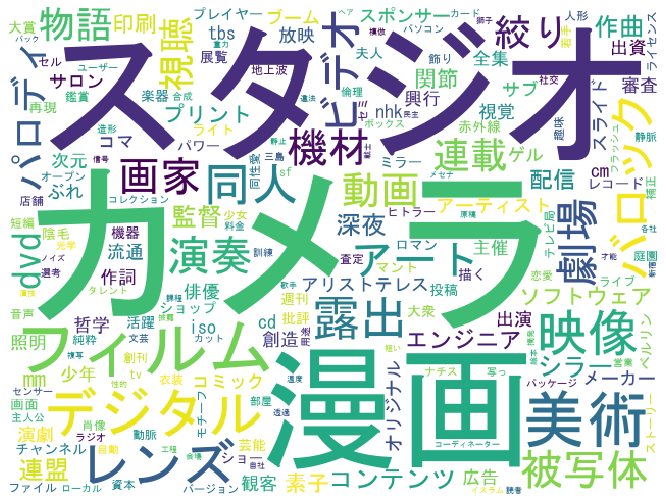

In [9]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

cate = 'art' # ここを'animal', 'art', 'economy', 'law', 'plant', 'politics'のいずれかに書き換えてみましょう（

wordfreq = {w[0]:w[1] for w in dic[cate]}

wc = WordCloud(background_color="white",
    font_path="C:\Windows\Fonts\msgothic.ttc", # Windows
    #font_path="/System/Library/Fonts//AppleSDGothicNeo.ttc", # Mac OS
    #font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf', # Colaboratory
    width=640,height=480).generate_from_frequencies(wordfreq)
plt.figure(figsize=(12,9))
plt.imshow(wc)
plt.axis("off")
plt.savefig('fig/TopicAnalysis1-1.png') # 図を画像として保存

## 4. tf-idfベクトルによる文書の類似度

### 4.1 カテゴリ間の類似度

2.4では`TfidfVectorizer`という関数を使って`vectorizer`というモデルを得ました。   
`vectorizer = TfidfVectorizer(max_features=10000, max_df=5, min_df=3)`

さらにfit_transformというメソッドによって、分かち書きされた入力文`corpus`からtf-idfのベクトルを計算しましたよね。  
`X = vectorizer.fit_transform(corpus)`

実はこの`vectorizer`はその名の通り、`fit_transform`というメソッドで、分かち書きされた入力文をベクトル化してくれるオブジェクトでした。   
それでは、この各カテゴリの文書ベクトル同士の類似度を、コサイン類似度によって評価してみましょう。   
結果はBag-of-Wordsのときと同様、類似度行列として出力されます。 

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(X)
print(Categories)
print(similarity_matrix)

値が大きければ大きいほど、その二つのカテゴリの文書ベクトルが類似していることを意味します。   
例えばanimalとplanetの類似度は0.38902641で、ほかのカテゴリよりも明らかに高いですね。     
また、lawとpoliticsの類似度は0.71316576です。こちらはもっと強い関係があるようです。  
類似度行列を詳しく見ると、こんなことが分かるでしょうか？
- 「動物」は「植物」と似ている
- 「芸術」はどれともあまり似てないけど、あえて言うなら「経済」
- 「経済」は「芸術」「法」「政治」と同程度似ている
- 「法」と「政治」は似ている

### 4.2 未知の文書はどのカテゴリの記事かを推定しよう

カテゴリが不明なある記事がどのカテゴリの記事なのかを推定する課題に挑戦してみましょう。   
`text/wikipedia_sample.json`には、上で読み込んだ`wikipedia.json`と同じ形式ですが、そこには含まれていない記事が記録されています。   
6種類のカテゴリについて1つずつ用意しました。   
jsonファイルの中を覗けば`Category`も`title`も書いてありますが、もしそれらが分からなかったと仮定して、記事の本文（`text`の要素）だけからどのカテゴリの記事かを推定してみましょう。

まず`text/wikipedia_sample.json`を読み込みます。

In [ ]:
with open('text/wikipedia_sample.json', 'r', encoding='utf-8') as fi:
    wiki_sample = json.load(fi)

上ですでに学習済みのvectorizerを使って、未知の文（プログラム中はsampleという変数に代入される）をベクトル化します。  
このベクトルの次元は当然10,000次元です。

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# 以下でサンプルのwikipedia記事を読み込みます。このとき、辞書のラベルとして指定されているカテゴリが正解のカテゴリです
# 下のうちいずれかの行をコメントアウトして記事を1つ読み込んでください。
sample = wiki_sample['animal']['3905242']['wakati'].replace('\n', '') # 正解は「動物」
#sample = wiki_sample['art']['3912545']['wakati'].replace('\n', '') # 正解は「芸術」
#sample = wiki_sample['economy']['204500']['wakati'].replace('\n', '') # 正解は「経済」
#sample = wiki_sample['law']['3000191']['wakati'].replace('\n', '') # 正解は「法」
#sample = wiki_sample['plant']['2043006']['wakati'].replace('\n', '') # 正解は「植物」
# sample = wiki_sample['politics']['725095']['wakati'].replace('\n', '') # 正解は「政治」
sample_tfidf = vectorizer.transform([sample])

sample_tfidf.shape


この記事について、tf-idf値が高い単語のリストを表示してみましょう。   
ただし、ここでリストされるのはsampleに登場するすべての単語ではなく、tf-idfを計算するのに使用したvectorizerを学習する際に考慮した10000個の単語のみです。   
sampleの中に、この10000種類に含まれている単語がある程度登場していないと、この記事の特徴量としては非常に粗（スパース）になってしまうので、カテゴリの推定はうまく行かないでしょう。   

In [ ]:
for x in sample_tfidf[0].nonzero()[1]:
    print(feature_names[x], sample_tfidf[0,x])

sampleのtf-idfベクトルと、6種類の各カテゴリから計算したtf-idfベクトルとのコサイン類似度を計算し、その結果を棒グラフで描画します。   
類似度の高いカテゴリほど、棒グラフが高くなります。   
正しいカテゴリの棒グラフが最も高くなったでしょうか？   
政治と法はもともと文書ベクトル同士が近いので、この間の判別は難しそうです。

In [ ]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

sample_sim_matrix = cosine_similarity(sample_tfidf, X)[0]

plt.bar([x for x in range(len(sample_sim_matrix))], sample_sim_matrix.flatten(), tick_label=Categories)
print(Categories)
print(sample_sim_matrix)
plt.savefig('fig/TopicAnalysis1-2.png') # 図を画像として保存